In [1]:
# у нового scipy проблема с совместимостью со statsmodels ==> делаем даунгрейд

!pip install imgaug==0.2.5
!pip install scipy==1.2.0

import imgaug
import scipy

print(imgaug.__version__)
print(scipy.__version__)

0.2.5
1.2.0


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings("ignore")
from google.colab import files

## utils

In [0]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
      
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

## main

In [0]:
# Я не знаю, почему не читается файл
# url = 'https://raw.githubusercontent.com/RomanovIV/hse_home_projects/master/'
# with open(url+'data/data_project_2.pickle', 'rb') as f:
#     df = pickle.load(f)
# df.head()

In [5]:
!wget https://raw.githubusercontent.com/RomanovIV/hse_home_projects/master/data/data_project_2.pickle
df = pd.read_pickle('data_project_2.pickle')
print(df.shape)
df.head()

--2019-05-24 18:37:03--  https://raw.githubusercontent.com/RomanovIV/hse_home_projects/master/data/data_project_2.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48982 (48K) [application/octet-stream]
Saving to: ‘data_project_2.pickle’

data_project_2.pick 100%[===================>]  47.83K  --.-KB/s    in 0.01s   

2019-05-24 18:37:03 (3.20 MB/s) - ‘data_project_2.pickle’ saved [48982/48982]

(1094, 3)


,group,date,target
0,3,2018-03-15,1.0
1,3,2018-03-16,2.0
2,4,2018-03-16,2.0
3,3,2018-03-19,17.0
4,4,2018-03-19,19.0


In [6]:
df['group'].value_counts()

3    221
4    220
6    219
5    219
7    215
Name: group, dtype: int64

Посмотрим на ряд

(221, 4)


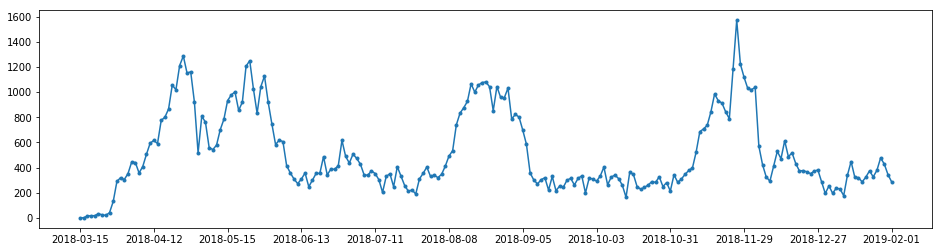

In [7]:
df_our = df[df['group']==3].reset_index()
print(df_our.shape)
plt.figure(figsize=(16,4))
plt.plot(df_our['date'], df_our['target'], marker='.')
plt.xticks(df_our['date'][::20])
plt.show()

In [8]:
dates = pd.to_datetime(df_our['date']).dt.date.values
data = df_our['target']
data.describe()

count     221.000000
mean      513.561086
std       313.225307
min         1.000000
25%       306.000000
50%       378.000000
75%       748.000000
max      1571.000000
Name: target, dtype: float64

Похоже, что ряд не является стационарным. Невооруженным глазом видны циклические изменения и отсутствие тренда. Все значения положительные

Проверим ряд на стационарность

In [0]:
# Используем ADF и KPSS тесты

def check_stationary(_data, regression='c', conf=0.01):
    test_ADF = sm.tsa.adfuller(_data, regression=regression)
    test_KPSS = sm.tsa.kpss(_data, regression=regression)
    
    # H0: не стационарный
    print('ADF p-value: ', test_ADF[1])
    if test_ADF[1]<conf: 
        print('stationary')
    else:
        print('non-stationary')
    
    # H0: стационарный
    print('KPSS p-value: ', test_KPSS[1])
    if test_KPSS[1]<conf: 
        print('non-stationary')
    else:
        print('stationary')

In [10]:
check_stationary(data)

ADF p-value:  0.001701170595179989
stationary
KPSS p-value:  0.1
stationary


Тем не менее график говорит, что в ряде есть аддитивная цикличность. Попробуем найти период цикличности

In [0]:
df_our["date"] = pd.to_datetime(df_our["date"])

In [0]:
df_our["month"] = df_our["date"].dt.month

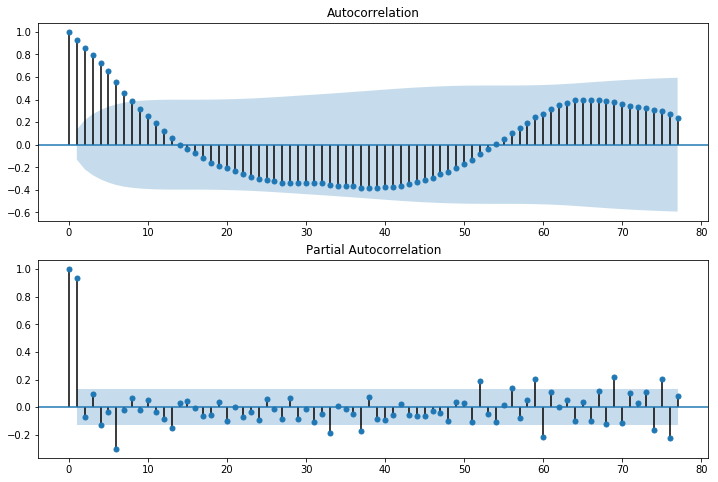

In [13]:
lags = 77
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data, lags=lags, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data, lags=lags, ax=ax2)

По значениям PACF сложно определить период цикличности, поэтому, ориентируясь на ближайший пик в колебаниях ACF, будем считать, что период равен 64

<Figure size 432x288 with 0 Axes>

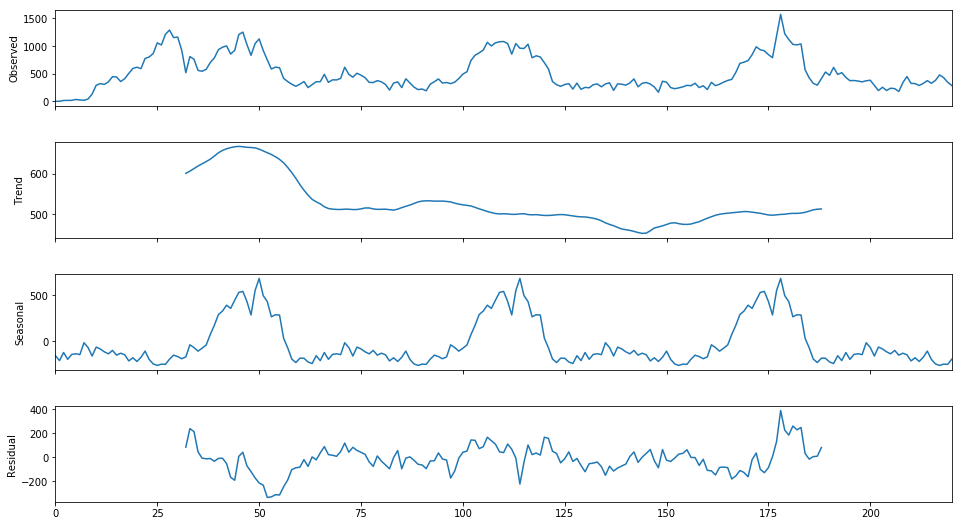

In [14]:
period = 64

decomposition = seasonal_decompose(data, model='additive', freq=period, extrapolate_trend=0)
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8);

Цикличность модели неплохо совпадает с наблюдаемой

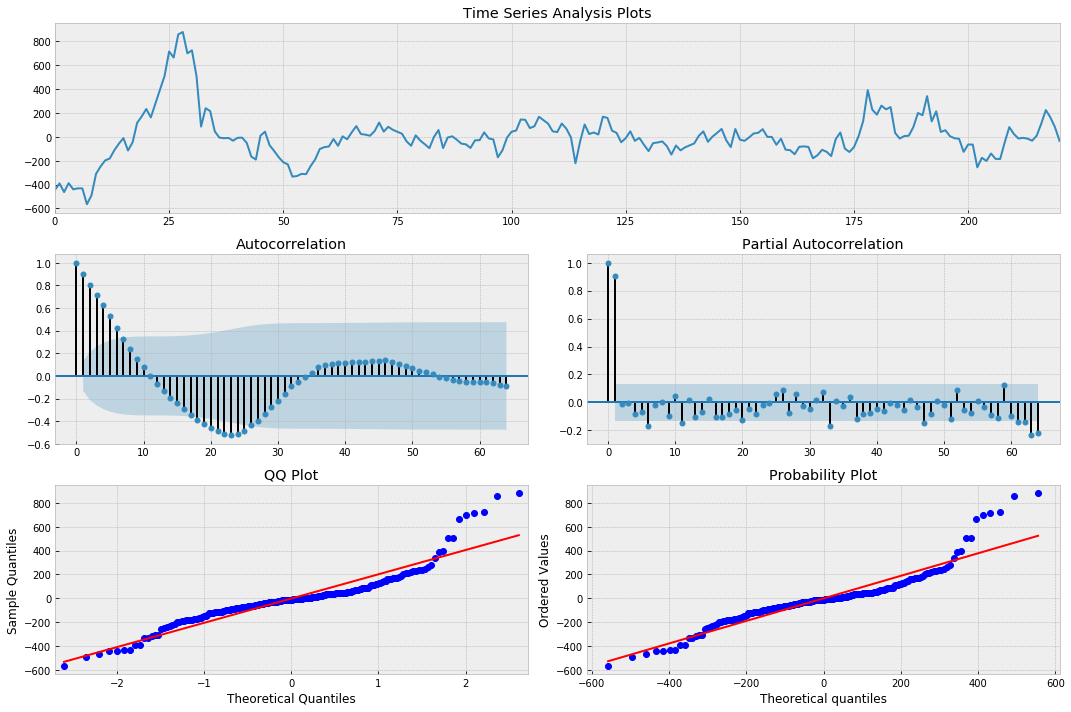

In [15]:
half_period = period // 2

trend = decomposition.trend
trend[:half_period] = trend[half_period]
trend[-half_period:] = trend[-(half_period+1):-half_period].values[0]
seasonal = decomposition.seasonal

data_sdecomp = data - seasonal - trend
tsplot(data_sdecomp, lags=period)

В целом выглядит неплохо, проверим ряд на стационарность

In [16]:
check_stationary(data_sdecomp)

ADF p-value:  0.005204332566404683
stationary
KPSS p-value:  0.1
stationary


Подберем лучшую ARMA модель для полученного ряда

In [0]:
def _get_best_model(TS, p=6, q=6):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    p_rng = range(p)
    q_rng = range(q)
    for i in p_rng:
        for j in q_rng:
            try:
                tmp_mdl = smt.ARMA(TS, order=(i,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, j)
                    best_mdl = tmp_mdl
            except: continue
    print('the best aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

In [18]:
_, order, model = _get_best_model(data_sdecomp)

the best aic: 2579.70798 | order: (5, 3)


In [19]:
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                 target   No. Observations:                  221
Model:                     ARMA(5, 3)   Log Likelihood               -1280.854
Method:                           mle   S.D. of innovations             77.767
Date:                Fri, 24 May 2019   AIC                           2579.708
Time:                        18:37:33   BIC                           2610.291
Sample:                             0   HQIC                          2592.057
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ar.L1.target     0.1119      0.067      1.660      0.098      -0.020       0.244
ar.L2.target     1.3931      0.042     32.822      0.000       1.310       1.476
ar.L3.target     0.3643      0.099      3.66

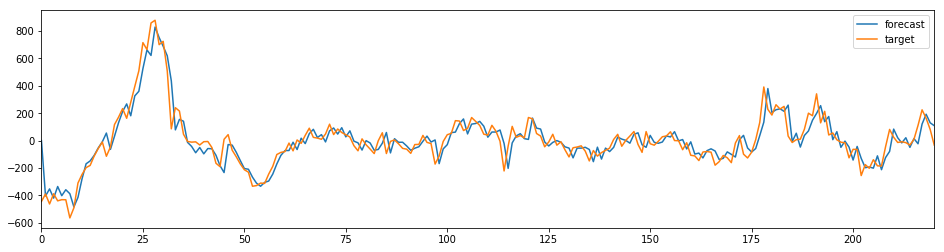

In [20]:
fig, ax = plt.subplots(figsize=(16,4))
model.plot_predict(dynamic=False, ax=ax)
plt.show()

Посмотрим на ошибки модели

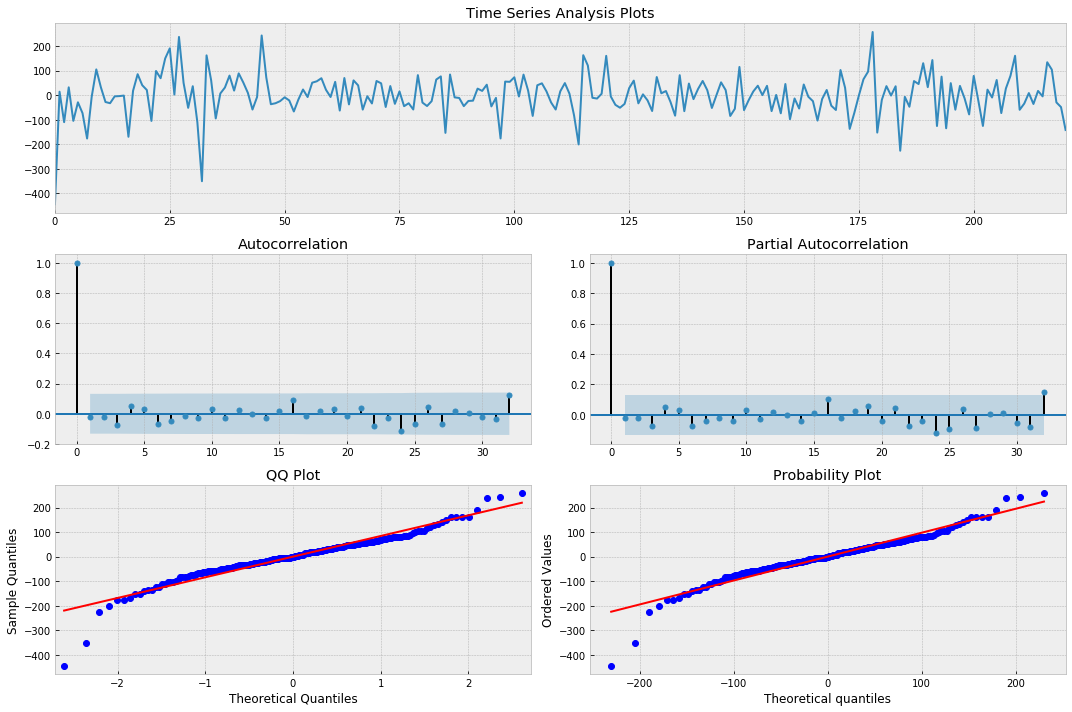

In [21]:
tsplot(model.resid, lags=half_period)

Все неплохо. Спрогнозируем ряд на месяц вперед

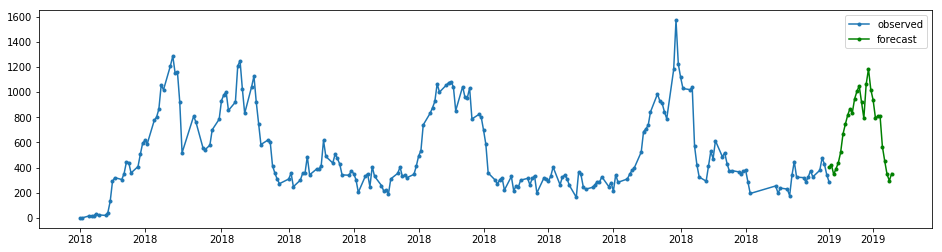

In [22]:
forecast_len = 28

ARMA_forecast, _, _ = model.forecast(forecast_len)
trend_forecast = trend[-1:].values[0]
seasonal_forecast = seasonal[-60:][:forecast_len]
forecast = ARMA_forecast + trend_forecast + seasonal_forecast

FILL_ME =  []
for i in range(1, forecast_len+1):
    FILL_ME.append('2019-02-{}'.format(i))
    
df_forecast = pd.DataFrame({'forecast': forecast, 'date': FILL_ME})
df_our_ = df_our.append(df_forecast, ignore_index=True)

plt.figure(figsize=(16,4))
plt.plot(df_our_['date'], df_our_['target'], marker='.', label='observed')
plt.plot(df_our_['date'], df_our_['forecast'], marker='.', color='g', label='forecast')
plt.xticks(df_our_['date'][::20])
plt.legend()
plt.show()

In [0]:
df_forecast.to_csv('forecast.csv', index=False)
files.download('forecast.csv')